# XGBoost for Time Series

Original tutorial: https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

## Import Packages

In [119]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

## Define Functions

In [120]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [121]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [122]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    
    # fit model
    model = XGBRegressor(
        objective='reg:squarederror', 
        n_estimators = 1000
    )
    
    model.fit(trainX, trainy)
    
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    
    return yhat[0]

In [123]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(data, n_test)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    
    return error, test[:, -1], predictions

## Run the Algorithm

### Load Data

In [124]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv

--2021-01-16 14:48:34--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.32.133, 199.232.32.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.32.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6220 (6.1K) [text/plain]
Saving to: ‘daily-total-female-births.csv.1’

daily-total-female- 100%[===================>]   6.07K  --.-KB/s    in 0s      

2021-01-16 14:48:34 (122 MB/s) - ‘daily-total-female-births.csv.1’ saved [6220/6220]



In [125]:
# load the dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
values = series.values

In [126]:
series.head(3)

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30


## Plot the Data

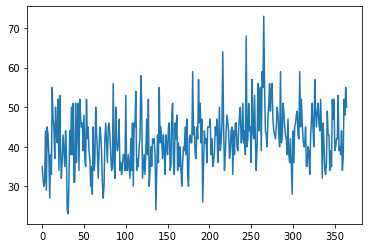

In [127]:
pyplot.plot(values)
pyplot.show()

### Process Time Series to Supervised Learning Format

In [128]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)

In [129]:
data[:10]

array([[35., 32., 30., 31., 44., 29., 45.],
       [32., 30., 31., 44., 29., 45., 43.],
       [30., 31., 44., 29., 45., 43., 38.],
       [31., 44., 29., 45., 43., 38., 27.],
       [44., 29., 45., 43., 38., 27., 38.],
       [29., 45., 43., 38., 27., 38., 33.],
       [45., 43., 38., 27., 38., 33., 55.],
       [43., 38., 27., 38., 33., 55., 47.],
       [38., 27., 38., 33., 55., 47., 45.],
       [27., 38., 33., 55., 47., 45., 37.]])

### Evaluate

In [133]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)

/home/moby/miniconda3/envs/env/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


>expected=42.0, predicted=44.5
>expected=53.0, predicted=42.5
>expected=39.0, predicted=40.3
>expected=40.0, predicted=32.5
>expected=38.0, predicted=41.1
>expected=44.0, predicted=45.3
>expected=34.0, predicted=40.2
>expected=37.0, predicted=35.0
>expected=52.0, predicted=32.5
>expected=48.0, predicted=41.4
>expected=55.0, predicted=46.6
>expected=50.0, predicted=47.2
MAE: 5.957


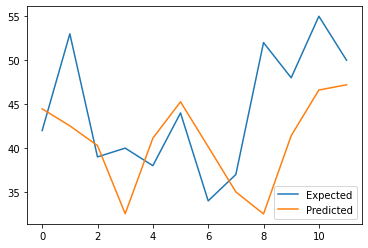

In [132]:
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()